### this notebook load calcium data from Bartos lab (Hannah's data) and detect and cluster the sequences. 

In [33]:


# code from laptop
import seaborn as sns

from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
import mtools as mot
from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
import scipy.stats as stats
from rastermap import Rastermap
import scipy.signal
from helper_functions import separate_in,separate_in_2d_array,linearize_2d_track_single_run
import configparser
import os







plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths
mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')# the location of data to load and save

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']
datafolder= config['paths']['datafolder']
skeletonsfolder= config['paths']['skeletonsfolder']

sleep__beforelearning = {'478':['session02','session03'],'480':['session02','session03'],'481':['session02','session03'],'483':['session02','session03'],'485':['session02','session03']}# before learning
sleep_leaned_before = {'478':['session02','session03'],'480':[],'481':['session02'],'483':['session02','session03'],'485':['session02']}# learned before task
sleep_leaned_after = {'478':['session05'],'480':[],'481':['session04'],'483':['session05','session06'],'485':['session04']}# learned after task


days= np.arange(0 ,32)# names to load data
daysstr = ["%02d" % (i,) for i in days]
months = np.arange(0,13)
monthsstr = ["%02d" % (i,) for i in months]
year=str(2022)
dates = []
for m in monthsstr:
    for d in daysstr:
        dates.append(year+m+d)




## initializtion


In [34]:
folders = ['478']# Name of the animals' folder to analyse
place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'
nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'# what clustering algorithm will be used
Mode = 0 # this belongs to the old code and can be removed
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq
thr_burts = .5# threshold for burst detection
winlen = 1000*fs# 10 sec cunnks for burst detection
tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates

speed_thr=0# threshold to remove datapoint with low speed (Must be always  0, otherwise wrong results)
burst_length=0.5 # Duration of bursts (hardcoded in mtools (Tspare=.5))
burst_len=str(burst_length)+'s'


if clusteringmethod =='DB':# clustering algorithm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



task = ['task_learning','task_learned']
print('Taks that are used to compute active cells: ', *task, sep=' and ')


descriotor='No_chunk_'+burst_len+'_'+signal_type#+'Randomized_seqs'

Taks that are used to compute active cells:  and task_learning and task_learned


## Get the index of cells that are acitve in all sessions

task_learning
478\20220214_gcamp6f478_task_learning.mat
478\20220215_gcamp6f478_task_learning.mat
478\20220216_gcamp6f478_task_learning.mat
478\20220217_gcamp6f478_task_learning.mat
task_learned
478\20220318_gcamp6f478_task_learned.mat
478\20220319_gcamp6f478_task_learned.mat
478\20220320_gcamp6f478_task_learned.mat
478\20220321_gcamp6f478_task_learned.mat
478\20220327_gcamp6f478_task_learned.mat


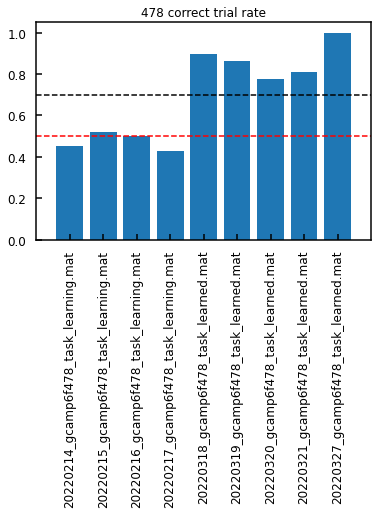

Number of active cells during tasks: 87


In [35]:
## Load data of all sessions of one animal
results_all_sess = mot.process_sessions(task, dates, folders, datafolder, signal_type)


# load skleton files and inedex of Place cells

In [36]:



skel = np.load(skeletonsfolder+folders[0]+'_skeleton.npy',allow_pickle=True) 
skel=skel.item()

# if place_cells:
#     dir_of_run='L'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_L=saved_idx['sig_PC']

#     dir_of_run='R'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_R=saved_idx['sig_PC']


#     significant_pc=sig_pc_L|sig_pc_R
#     cell_types='PC'
#     #cell_types='non_pc'

#     if cell_types=='Non_PC':
#         significant_pc=~significant_pc
# elif place_cells==False:
#         cell_types='All'
cell_types='All'

place_cell_name=cell_types


In [37]:



# =============================================================================

significant_pc=[]
data_all_sessions, spks = mot.process_animal_data(task, dates, folders, datafolder, signal_type,
                                              burst_len, tau, place_cells, significant_pc,
                                              results_all_sess['newidx'], winlen, thr_burts, results_all_sess['session_mask'], skel)


Processing: 478/20220214_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220215_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220216_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220217_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220318_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220319_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220320_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220321_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220327_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5


## Load data of different sessions and merge them.

In [38]:
# # show an example of sequence detection
# data = mot.loadmat('C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/485/20220310_gcamp6f485_task_learned.mat')

# # --- Preprocess the session signal ---

# # Retrieve metadata and compute sampling frequency.
# metadata = data['metadata']
# # Select cells active in all sessions using the provided index.
# true_cell_idx3 = np.array(metadata['CellRegCellID'])
# STMx2 = data['STMx'][signal_type][true_cell_idx3[newidx]]
# winlen=np.shape(STMx2)[1]-1
# poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

# #xlim=[9330,11500]
# xlim=[12430,12550]

# speed_trl=[]
# fig, fig2, ax, ax0, ax1, ax2 = mot.plot_sequences_new(STMx2,seqs,bursts,id_peaks,thr_burts,fs,speed_trl,np.asarray(poprate),xlim)

# #ax0.set_xlim([10, 100])
# #ax.set_xlim([10, 100])

# ax0.set_xlim([220,400])
# ax.set_xlim([220,400])

# ax.set_ylim([0, 320])
# hide_spines(ax=ax)
# hide_spines(ax=ax0)
# hide_spines(ax=ax1)
# hide_spines(ax=ax2)

# # fig.savefig(savefolder+'sample Burst.svg',dpi=300)
# # fig2.savefig(savefolder+'sample Burst sorted.svg',dpi=300)

# # plt.show()

# # plt.xlim([10,111])
# # plt.xlim([10,141])

In [39]:
combined_dicts = [data_all_sessions, results_all_sess['session_mask'] ]
with open(savefolder+folders[0]+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer','wb') as f:
    pickle.dump(combined_dicts, f)       


## Generate masks for differenct behaviral epochs

In [40]:



# =============================================================================

Masks, sess_info, cond_info = mot.generate_masks(data_all_sessions, results_all_sess['session_mask'], results_all_sess['ncells'])
# =============================================================================


In [42]:
Mask_and_sess = [Masks, results_all_sess['session_mask']]

with open(savefolder+folders[0]+'Mask_with_correct_cells','wb') as f:
    pickle.dump(Mask_and_sess, f) 

In [43]:
# ## some visualizations. Can be commented just for visualiztion!
# # example of spike raster detected from the tranisent neural activity of all cells

# plt.imshow(sess_info['Spike_binary_cells'],vmin =0, vmax=.05, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)

# ## visualize the transient rasters with rastermap

# model = Rastermap(n_components=1, n_X=90).fit(sess_info['extract'])# compute raster map based on the data of task x
# # compute correlation between speed and each cells activity

# isort = np.argsort(model.embedding[:,0])


# Sfilt=sess_info['extract'][isort, :]
# Sfilt = stats.zscore(Sfilt, axis=1)
# sorted_seqs=[]
# for seq in seqs:
#     sorted_seqs.append(np.ravel([np.where(isort==x)[0] for x in seq]))# sorting seqs according to rastermap



# plt.figure(figsize=(42,12))
# plt.subplot(211)

# plt.plot(np.asarray(sess_info['pop_rate'])/100,color='r')
# plt.eventplot(sess_info['id_peaks'])
# #plt.plot(sess_info['speed'],alpha=.2)
# plt.title(fol+'  Threshold=' +str(thr_burts),fontsize=34)
# plt.xlim([90010,100000])
# plt.ylim([0,3])

# plt.subplot(212)
# plt.imshow(Sfilt,vmin =0, vmax=3, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)
# plt.xlim([90010,100000])

## Cluster all detected sequences

cluster [] is removed
(44, 44)
exclude cluster is  [] mixed clusters are  [ 4.96818798 23.         24.        ]
(43, 43)
exclude cluster is  [] mixed clusters are  [ 4.69038056 15.         17.        ]
(42, 42)
exclude cluster is  [] mixed clusters are  [ 4.65513125 19.         32.        ]
(41, 41)
exclude cluster is  [] mixed clusters are  [ 4.55272067 24.         29.        ]
(40, 40)
exclude cluster is  [] mixed clusters are  [ 4.40438064 19.         29.        ]
(39, 39)
exclude cluster is  [] mixed clusters are  [ 4.08140518 27.         28.        ]
(38, 38)
exclude cluster is  [] mixed clusters are  [ 4.00175652 16.         17.        ]
(37, 37)
exclude cluster is  [] mixed clusters are  [ 3.9172992 12.        14.       ]
(36, 36)
exclude cluster is  [] mixed clusters are  [ 3.63193318 15.         16.        ]
(35, 35)
exclude cluster is  [] mixed clusters are  [ 3.63058973 18.         19.        ]
(34, 34)
exclude cluster is  [] mixed clusters are  [ 3.77610297 15.         18. 

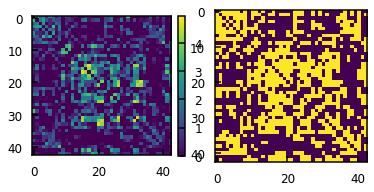

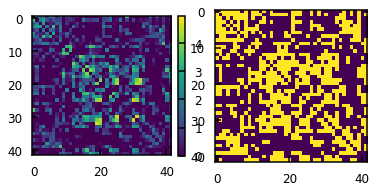

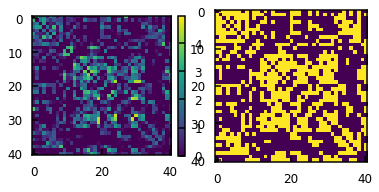

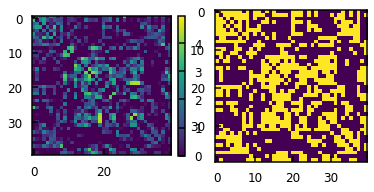

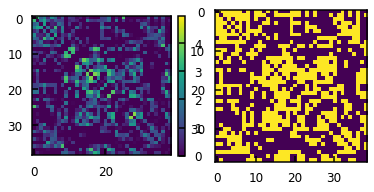

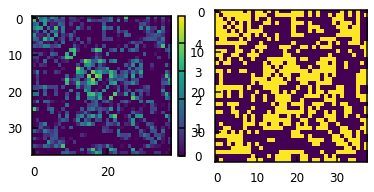

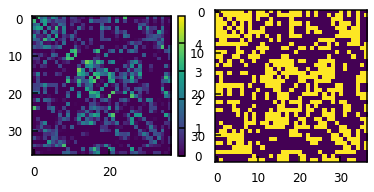

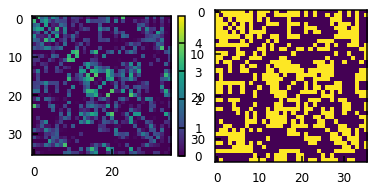

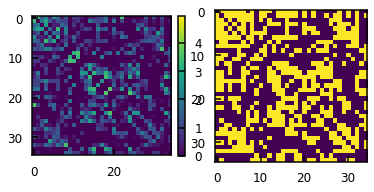

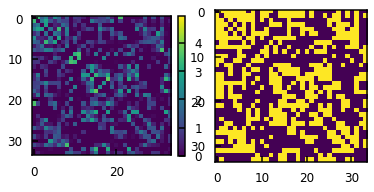

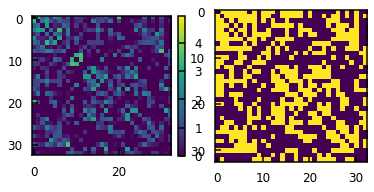

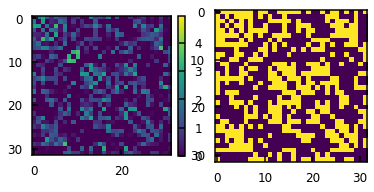

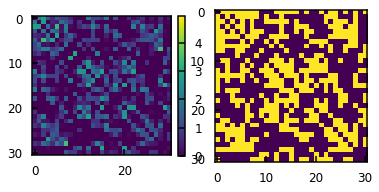

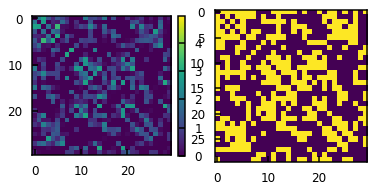

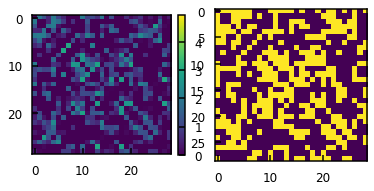

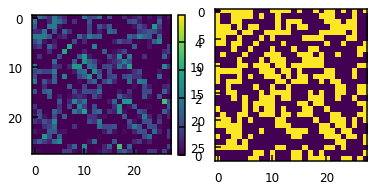

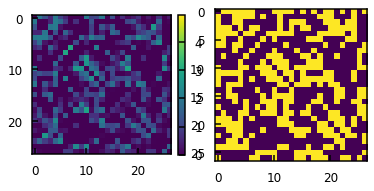

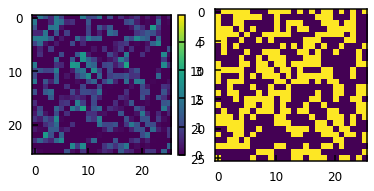

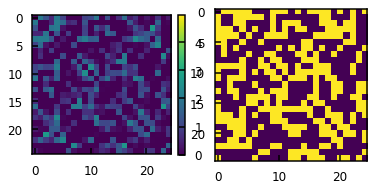

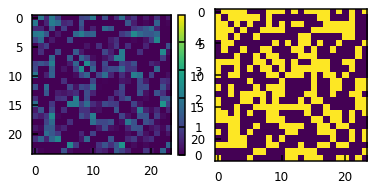

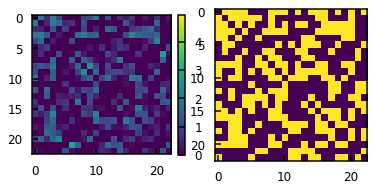

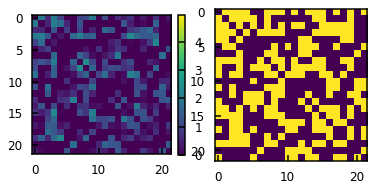

In [44]:
# clustering sequences

seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
bursts=sess_info['bursts']
plot_figure=True

#*************** compute clusters from sequences ***************
repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seqs,nrm);
ids_clust = mot.cluster(bmat,zmat,clstr_param)
temp_info = mot.templates(bursts,seqs,nrm,ids_clust,min_ratio = min_ratio)
print('cluster', temp_info['exclude'] ,'is removed')
#temp_info_org=np.copy(temp_info['template'])
temp_info_test = copy.deepcopy(temp_info)
temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seqs,bursts,plot_figure,min_ratio=.1,z_thr=2.5)
#id_peaks=dats['sp_idpeak']
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
sess_info['template'] = temp_info_new['template']

if len(sess_info['template']) != len(np.unique(sess_info['ids_clust'])):# retrun error if cluster number and template length are not equal
    raise ValueError("Template lenght must be qual to cluter numbers")

sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
with open(savefolder+folders[0]+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
    pickle.dump(sess_inf_plus_mask, f) 

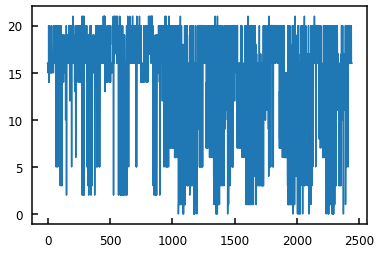

In [45]:
plt.plot(sess_info['ids_clust'] )

In [46]:
savefolder+folders[0]+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results_new/478Sesseion_info_All AllNo_chunk_0.5s_transients'

In [47]:
## run til here, the folloig cods are not used for the manuscript

In [48]:
stop

NameError: name 'stop' is not defined

# Clustering shuffled sequences

In [ ]:
# shuffled_seqs=[]
# shuffled_bursts=[]
# for iseq, seq in enumerate(seqs):

#     indices = np.arange(len(seq))
#     np.random.shuffle(indices)
#     shuffled_seqs.append(seq[indices])
#     shuffled_bursts.append(replace_rows(bursts[iseq], seq, seq[indices]))

In [ ]:
#poprate,id_peaks,bursts,seqs,spike_times,rasters = mot.binned_burst(dats['sp_data'],winlen,thr_burts,fs,timewins)
# seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# bursts=sess_info['bursts']

plot_figure=True


# #id_peaks=sess_info['id_peaks']
# #*************** compute clusters from sequences
# repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(shuffled_seqs,nrm);
# ids_clust = mot.cluster(bmat,zmat,clstr_param)
# temp_info = mot.templates(shuffled_bursts,shuffled_seqs,nrm,ids_clust,min_ratio = min_ratio)
# print('cluster', temp_info['exclude'] ,'is removed')
# #temp_info_org=np.copy(temp_info['template'])
# temp_info_test = copy.deepcopy(temp_info)
# temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,shuffled_seqs,shuffled_bursts,plot_figure,min_ratio=.1,z_thr=2.5)
# #id_peaks=dats['sp_idpeak']
# sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
# sess_info['seqs']=shuffled_seqs
# sess_info['bursts']=shuffled_bursts

# sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
# with open(savefolder+fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(sess_inf_plus_mask, f) 

# Apply the masks and get the part of data you need. 

### Save data of outward runs for Place feild analysis

In [16]:

# add the mask for speed. speed threshold is set to 5.
smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr


# select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#sessin_numbers=[6]
#sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#celid=23# number of sample cell to show in the plot

#cond_number=[3] # conditon name (outwards)
#cond_number=[8,9,10,11] # inwards
#cond_number=[0,1] # sampling
#cond_number=[6,7] # reward
for cond_number in ([2,3]):
        
    trial_type=0 # 1 is correct       0 is failed

    if trial_type==1:
        type_name='correct'
    elif trial_type==0:
        type_name='failed'



    phase=None#None#,1 # 0 is learning,    1 is learned,  None is both
    if phase==None:
        phase_name='all'
    elif phase==0:
        phase_name='learning'
    elif phase==1:
        phase_name='learned'
            


    # odd_even=1# even trials
    # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    # odd_even=0# odd trials
    # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    odd_even=None# all trials
    run_data_all=mot.apply_masks_test(sess_info,Masks,[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



    reversed_mapping = {v: k for k, v in cond_names.items()}
    print(reversed_mapping.get(cond_number,'Key not found'),len(run_data_all['trace_cells']))
    animal_direction=reversed_mapping.get(cond_number,'Key not found')
    #animal_direction = mot.find_condition(cond_number,cond_names)
    #print(animal_direction)
    run_data_all['template']=sess_info['template']
    with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        pickle.dump(dict(run_data_all), f)   
    #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')


outward_L 87
outward_R 87


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


In [ ]:
## to get the merged data of sampling, outward and reward for burst replay analysis 
cell_types='All'
descriotor='No_chunk_0.5s_transients'
for fol in ['478','481','483','485']:

    #savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
    #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
    #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
    #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
    #fol='481'
    #phase='all'
    filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

    #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info= data_all_tasks['sess_info']
    #Masks= data_all_tasks['Masks']# this mask does not include mask of correct trials of single cells


    filename_mask = fol+'Mask_with_correct_cells'
    Masks_ = np.load(join(savefolder, filename_mask), allow_pickle=True)# i added the correct masks for single cell data recently
    Masks=Masks_[0]


    #data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
    session_mask=Masks_[1]







 
    # add the mask for speed. speed threshold is set to 5.
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
    sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
    #sessin_numbers=[6]
    #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
    #celid=23# number of sample cell to show in the plot

    #cond_number=[3] # conditon name (outwards)
    #cond_number=[8,9,10,11] # inwards
    #cond_number=[0,1] # sampling
    #cond_number=[6,7] # reward
    for con_number in ([1,3,5],[0,2,4],[0,2,4,1,3,5]):
            
        trial_type=1 # 1 is correct       0 is failed

        if trial_type==1:
            type_name='correct'
        elif trial_type==0:
            type_name='failed'



        phase=None#None#None#,1 # 0 is learning,    1 is learned,  None is both
        if phase==None:
            phase_name='all'
        elif phase==0:
            phase_name='learning'
        elif phase==1:
            phase_name='learned'
                


        # odd_even=1# even trials
        # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        # odd_even=0# odd trials
        # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        odd_even=None# all trials
        run_data_all=mot.apply_masks_test(sess_info,Masks,con_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



        name_of_conds=' '.join([xn for xn,x in cond_names.items() if x in con_number])

        run_data_all['template']=sess_info['template']
        # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f)   
        #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')
        # with open(savefolder+fol+name_of_conds+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f) 

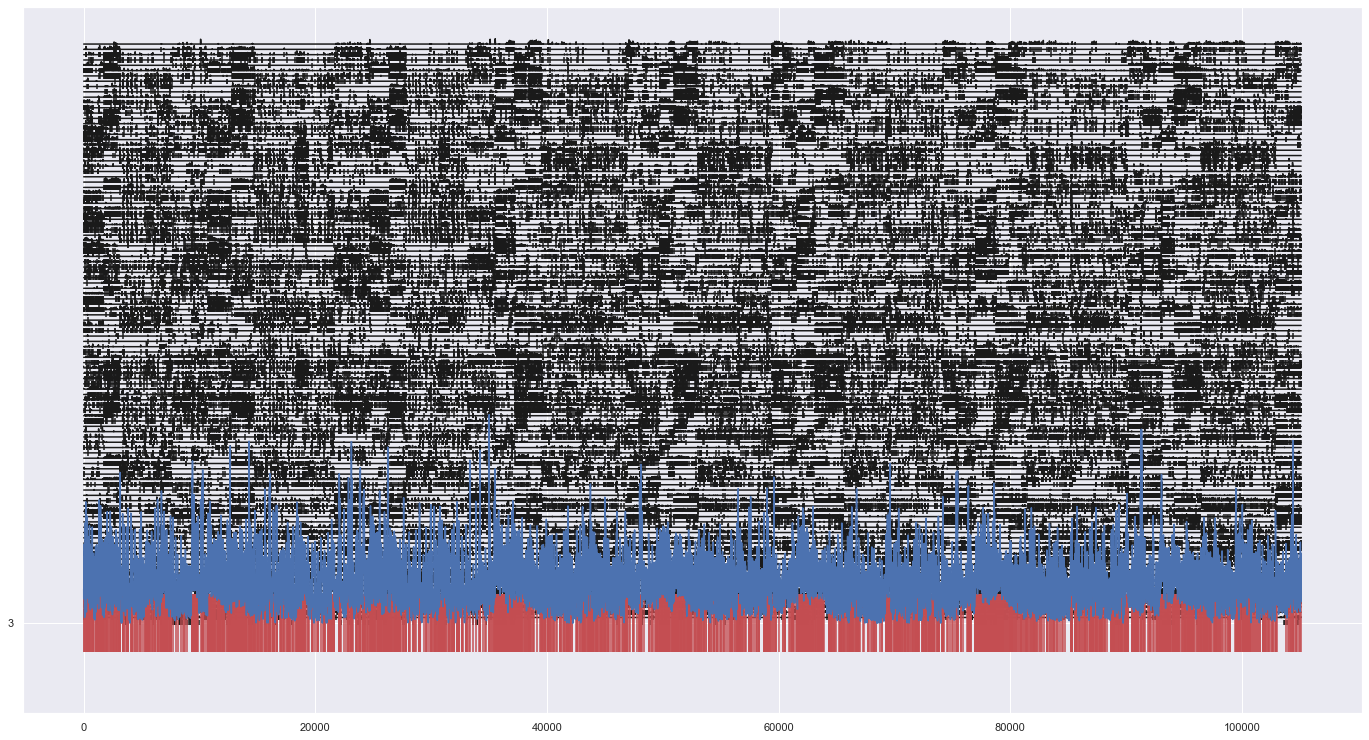

In [ ]:
plt.figure(figsize=(24,13))
for nr in range(len (sess_info['Spike_times_cells'])):
    plt.eventplot(sess_info['Spike_times_cells'][nr],linelengths=1,lineoffsets=nr,color='k')

    plt.plot(nr+1+sess_info['extract'][nr]/np.max(sess_info['extract'][nr]),color='k')

#plt.eventplot(data['spike_idx_cells'][1],linelengths=21,lineoffsets='4',color='k')

plt.eventplot(sess_info['id_peaks'],lineoffsets='3',color='r',linelengths=11)

plt.plot(np.asarray(sess_info['pop_rate'])/10)
#plt.xlim([0,2111])

In [ ]:

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first four colors
first_four_colors = color_cycle[:4]



## Finde the precentage of the place cells in a sequences

## plot the distribution of each cluster

In [ ]:
n_clusters=np.max(sess_info['ids_clust'])+1


In [18]:
Cluster_cunts_all={}
phase_c_f=1
state_c_f=1
n_clusters=np.max(sess_info['ids_clust'])+1

if phase_c_f==1:
    datamaode='Learned'
elif phase_c_f==0:
    datamaode='Learning'


if state_c_f==1:
    trialsmode='Correct'
elif state_c_f==0:
    trialsmode='Failed'



for icls,cls in enumerate(np.unique(sess_info['ids_clust'])):# itterat on clusters
    Cluster_cunts={}

    mas_clstr=(sess_info['ids_clust']==cls)# mask of one cluster

    learning_or_learned_mask=np.asarray(Masks['bursts_phase'])==phase_c_f
    correct_or_failed_mask= np.asarray(Masks['correct_failed_seqs'])==state_c_f

    dd=np.asarray(Masks['bursts_cond'])[mas_clstr & correct_or_failed_mask  & learning_or_learned_mask]
    
    
    # bursts on one cluster
    for kk in range(len(cond_names)):# itteration on condtions
        sumsclstr=[]
        #for dk in range(len(cond_names)):

        if list(cond_names.items())[kk][1]==kk:
            Cluster_cunts[list(cond_names.items())[kk][0]]=np.sum(dd==kk)

    Cluster_cunts_all[str(icls)]=Cluster_cunts



In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.rcParams.update({'font.size': 19})
# plt.rcParams['axes.titlesize'] = 19  # Set the title font size
# plt.rcParams['xtick.labelsize'] = 11  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 15  # You can adjust the font size as needed

# j = 4#int(np.ceil(np.sqrt(n_clusters)))
# k = 5#int(np.ceil(n_clusters / j))
# fig, axes = plt.subplots(j, k, figsize=(14, 8), sharex=True, sharey=True)
# axes = axes.flatten()

# for cltr_nbr_data in Cluster_cunts_all.keys():


# # Convert the data to a format suitable for Seaborn


#     merged_data = {'sampling': Cluster_cunts_all[cltr_nbr_data]['sampling_L'] + Cluster_cunts_all[cltr_nbr_data]['sampling_R'],
#                'outward': Cluster_cunts_all[cltr_nbr_data]['outward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_side'],
#                'reward': Cluster_cunts_all[cltr_nbr_data]['reward_L'] + Cluster_cunts_all[cltr_nbr_data]['reward_R'],
#                'inward': Cluster_cunts_all[cltr_nbr_data]['inward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_center']}

#     data_list = [{'Category': key, 'Value': value} for key, value in merged_data.items()]

#     # Create a DataFrame from the data
#     import pandas as pd
#     df = pd.DataFrame(data_list)

#     # Set the plot style (optional)

#     # Create a bar plot using Seaborn
#     #plt.figure(figsize=(5, 3))
#     sns.set()
#     #colors = sns.color_palette("default", n_colors=4)
    
#     current_palette = sns.color_palette()
#     sns.set(style="whitegrid")

#     sns.barplot(x='Category', y='Value', data=df, ax=axes[int(cltr_nbr_data)],palette=current_palette)

#     # Rotate x-axis labels for better readability
#     #axes[int(cltr_nbr_data)].set_xticks(rotation=90, ha='right')

#     # # Adding labels and title
#     #axes[int(cltr_nbr_data)].set_xlabel('Consitions')
#     axes[int(cltr_nbr_data)].set_xlabel('',fontsize=15)
#     axes[int(cltr_nbr_data)].set_ylabel('Sequence #' if int(cltr_nbr_data) % k == 0 else '',fontsize=16)
#     axes[int(cltr_nbr_data)].set_title('Cluster '+ cltr_nbr_data,fontsize=20)
#     # #plt.ylim([0,120])
#     # # Display the plot

# for i in range(n_clusters, j * k):
#     fig.delaxes(axes[i])

# plt.suptitle(fol+' '+datamaode+' '+trialsmode,fontsize=22)
# plt.tight_layout()
# plt.show()


In [ ]:
colorlist=["#FFD700",
"#00FFFF",
"#7346d0",
"#72d658",
"#d65171",
"#c09294",
"#6678c6",
"#ae3e83",
"#FFA500",#
"#4a7875",
"#cdd24b",
"#7b332e",
"#c98ccc",
"#d74f34",
"#45314e",
"#cf4dcc",
"#5f893e",
"#cac795",
"#c48840",
"#4f2a7e"]

#colorlist[-1]='#E5E5E5'# make bad cluster gray

## Plot the distribution of different conditions

In [ ]:
def generate_hex_colors(n):
    
    color_list = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        if color in color_list:
            continue
        color_list.append(color)

    return color_list

if len (colorlist)<=np.max(temp_info_new['ids_clust'][0])+1:
    # Example usage

    colorlist = generate_hex_colors(np.max(temp_info_new['ids_clust'][0])+2)


In [ ]:
cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3445: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3445: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]
c:\Users\hamed\Desktop\Hamed

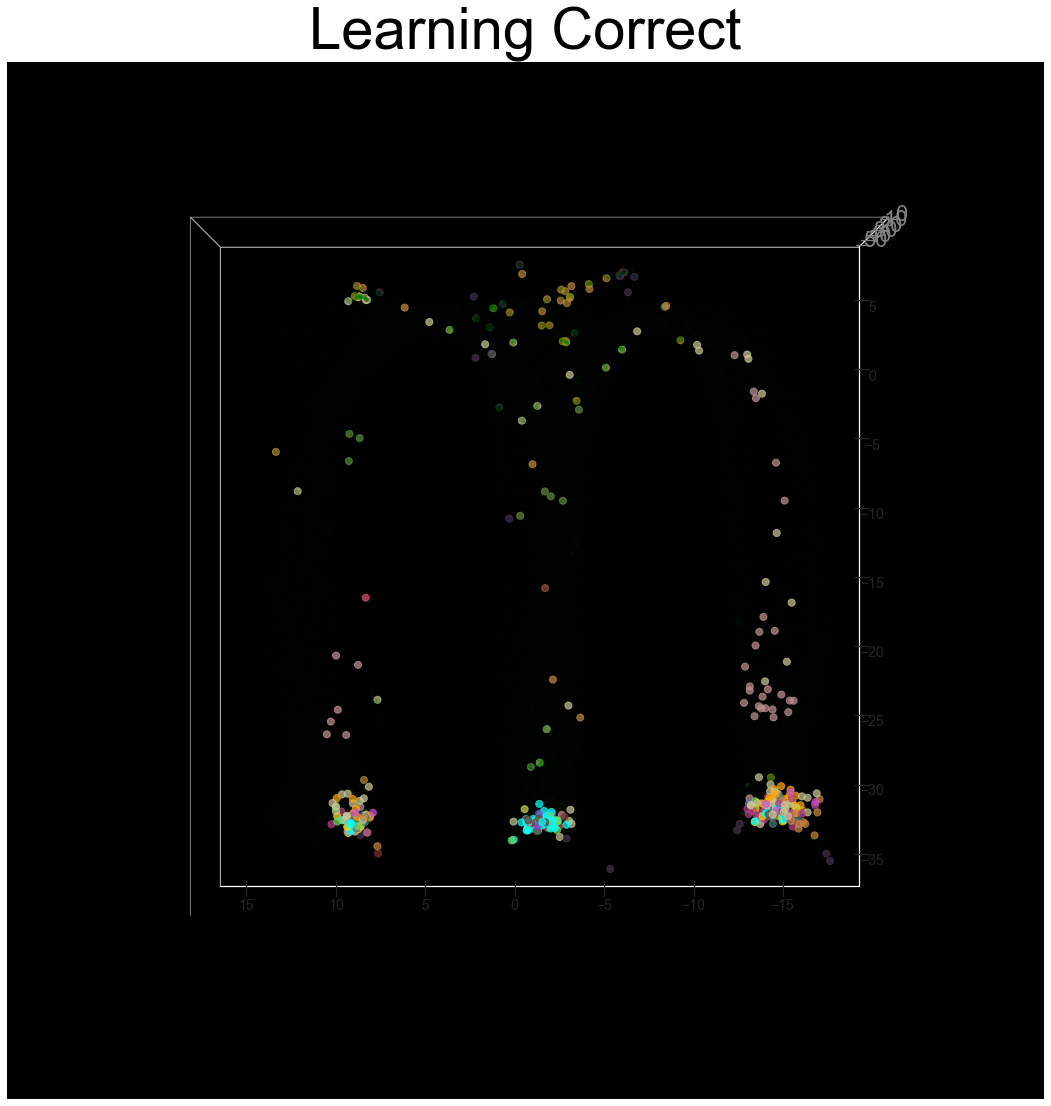

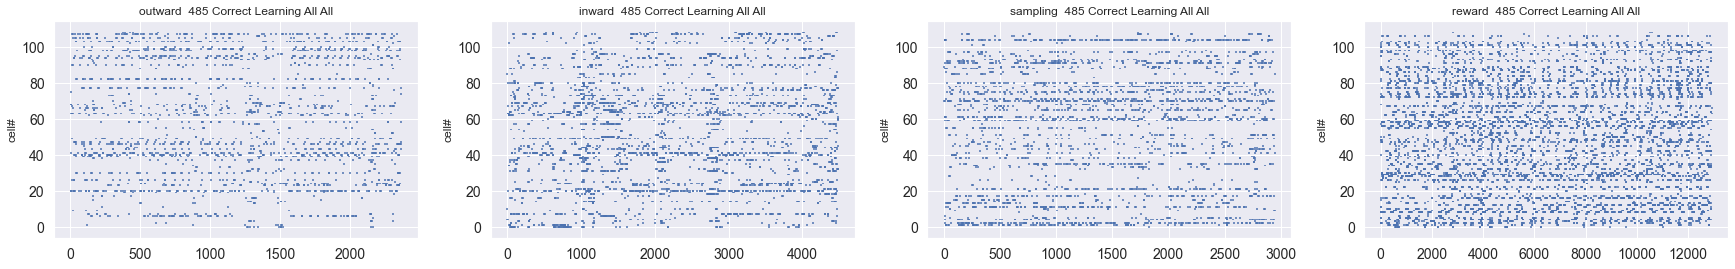

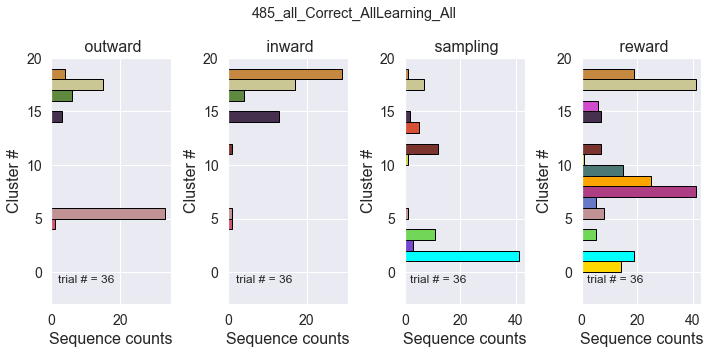

In [ ]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)
tasks=['sampling','outward','reward','inward']

plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

trial_type=1# 1 is correct       0 is failed
phase=0# 0 is learning,    1 is learned,  None is both


figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
#figs.patch.set_facecolor('black')




if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'



if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'

fig2,ax2=plt.subplots(1,4,figsize=(30,4))

fig,ax=plt.subplots(1,4,figsize=(10,5))
sns.set(style="darkgrid")
odd_even=None# all trials
cond_clst_idx={}
for icond,cond_number in enumerate(cond_numbers.keys()):

    name_cond=phase_name+' '+type_name

    if ('outward' in cond_number) | ('inward' in cond_number):
        speed_thr=0
        
    elif ('sampling' in cond_number) | ('reward' in cond_number):
        #continue
        speed_thr=0
    # add the mask for speed. speed threshold is set to 5.
    #speed_thr=0
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    run_data_all = mot.apply_masks_test(sess_info,Masks,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    trial_number=len(np.unique(run_data_all['trial_idx_mask']))



    ### plot 3d animal's position+speed
    ax5s.set_title(name_cond,fontsize=58,color='black')
    X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
    Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
    speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
    colrlst = np.asarray(colorlist)[run_data_all['ids_clust']]
    ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=50,c=colrlst,alpha=.71)
    ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='gray',alpha=.01)
    ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='green',alpha=.009)

    ax5s.set_facecolor('black') 
    ax5s.grid(False) 
    # ax5s.w_xaxis.pane.fill = False
    # ax5s.w_yaxis.pane.fill = False
    # ax5s.w_zaxis.pane.fill = False
    ax5s.xaxis.pane.fill = False
    ax5s.yaxis.pane.fill = False
    ax5s.zaxis.pane.fill = False

    ax5s.tick_params(axis='z', colors='gray',labelsize=22)
    ax5s.view_init(elev=-90, azim=90)
    #ax5s.view_init(elev=25, azim=-45)
    #ax5s.view_init(elev=0, azim=0)




    cond_clst_idx[cond_number] = run_data_all['ids_clust']
    #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
    #sns.set_palette(sns.color_palette(colorlist))
    sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
    for ic in range(len(ax[icond].patches)):
        ax[icond].patches[ic].set_facecolor(colorlist[ic])





    ax[icond].text(2,-1,'trial # = ' +str(trial_number))
    #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
    ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
    #ax[icond].set_xlim(0, 80)
    #ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
    ax[icond].set_title(f' {cond_number}',fontsize=16)

    ax[icond].set_ylabel('Cluster #',fontsize=16)
    ax[icond].set_xlabel('Sequence counts',fontsize=16)

    #plt.ylim([-1,np.max(sess_info['ids_clust'])])



    ispk=0
    for sspk in run_data_all['spike_idx_cells']:
        ax2[icond].eventplot(sspk,lineoffsets=ispk)
        ispk+=1
    ax2[icond].set_title(cond_number+'  '+fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
    ax2[icond].set_ylabel('cell#')


plt.suptitle(fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
plt.tight_layout()
#plt.suptitle('cluster_disribution'+fol+' '+type_name+' '+phase_name+' '+sigfilename_r[58:65]+' '+cell_types)
# fig.savefig(savefolder+ fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types+descriotor+' speed_thr='+str(speed_thr)+'_clusterdistribution.png', dpi=300, facecolor='w')
# fig.suptitle(fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+ ' cluster disribution of '+cell_types+descriotor+' speed_thr='+str(speed_thr))

# figs.savefig(savefolder+ fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types+descriotor+' speed_thr='+str(speed_thr)+'3d.png', dpi=300, facecolor='w')
# fig2.suptitle('raster plot '+fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types+descriotor+' speed_thr='+str(speed_thr))



In [ ]:
boz

NameError: name 'boz' is not defined

In [ ]:
# cond_numbers={}
# cond_numbers['outward']=[2,3,4,5] # conditon name (outwards)
# cond_numbers['inward']=[8,9,10,11] # inwards
# cond_numbers['sampling']=[0,1] # sampling
# cond_numbers['reward'] =[6,7] # reward


pairs={}
pairs['sampling']=['learned_sampling','learning_sampling']
pairs['outward']=['learned_outward','learning_outward']
pairs['reward']=['learned_reward','learning_reward']
pairs['inward']=['learned_inward','learning_inward']


# Save Sequence rate the data of learning and learned

In [ ]:
cond_results_allsess={}
equal_tial=False
odd_even=None
equality='nonequal'
if equal_tial==True:
    equality='equal'

#trial_type=1# 1 is correct       0 is failed

for ises, nameofsess in enumerate(session_mask.keys()):
    cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}

    for trial_type in range(2):
        #cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}

        sessin_numbers=[ises]#[0]#np.arange(len(session_mask))

        #nameofsess=list(session_mask.keys())[sessin_numbers[0]]

        phase=None # learned and learning
        if trial_type==1:
            typename='correct'
        elif trial_type==0:
            typename='failed'


        for cond_number_name in cond_numbers.keys():
            cond_number_= cond_numbers[cond_number_name]
            run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
            cond_results['firingrates'][cond_number_name+typename]=run_data_all_cond['fr']


            #print(nameofsess+cond_number_name+typename,fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate']))
            #cond_results['fr']['learning_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
            if len(run_data_all_cond['poprate'])>0:
                cond_results['fr'][cond_number_name+typename]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])
            # else:    
            #     cond_results['fr'][cond_number_name+typename]= 0
            #     print(nameofsess)

            cond_results['motif_nbr'][cond_number_name+typename]=len(np.unique(run_data_all_cond['ids_clust']))

            id_clusters = run_data_all_cond['ids_clust']
            labels, counts = np.unique(id_clusters, return_counts=True)
            cond_results['cluster_dist'][cond_number_name+typename] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}
            
        cond_results_allsess[nameofsess] = cond_results
        #print(cond_number_name,len(run_data_all_cond['poprate']))
        #print('ing',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))

with open(savefolder+fol+'fr'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
    pickle.dump(cond_results_allsess, f) 


c:\Users\hamed\Desktop\Hamed\BCN\sequence\code\TP7\mtools.py:3445: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]
